# 패키지 설치
pip 명령어로 의존성 있는 패키지를 설치합니다.



In [1]:
!pip install ratsnlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 333 kB/s 
     |████████████████████████████████| 2.8 MB 13.3 MB/s 
     |████████████████████████████████| 582 kB 46.3 MB/s 
     |████████████████████████████████| 57 kB 3.9 MB/s 
     |████████████████████████████████| 141 kB 39.1 MB/s 
     |████████████████████████████████| 596 kB 59.3 MB/s 
     |████████████████████████████████| 419 kB 21.0 MB/s 
     |████████████████████████████████| 3.3 MB 44.8 MB/s 
     |████████████████████████████████| 101 kB 9.8 MB/s 
     |████████████████████████████████| 880 kB 74.0 MB/s 
     |████████████████████████████████| 96 kB 5.6 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=fe1317ff4e95360cd83b61f14fc0277da9454a02f059002a830e525d0ce3fb53
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Suc

# 구글 드라이브 연동하기
모델 체크포인트 등을 저장해 둘 구글 드라이브를 연결합니다. 자신의 구글 계정에 적용됩니다.

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


# 각종 설정
모델 하이퍼파라메터(hyperparameter)와 저장 위치 등 설정 정보를 선언합니다.

In [3]:
from ratsnlp.nlpbook.classification import ClassificationDeployArguments
args = ClassificationDeployArguments(
    pretrained_model_name="beomi/kcbert-base",
    downstream_model_dir="/gdrive/My Drive/nlpbook/checkpoint-doccls",
    max_seq_length=128,
)

downstream_model_checkpoint_fpath: /gdrive/My Drive/nlpbook/checkpoint-doccls/epoch=0-val_loss=0.26.ckpt


# 모델 로딩
파인튜닝을 마친 모델과 토크나이저를 읽어 들입니다.

In [4]:
import torch
from transformers import BertConfig, BertForSequenceClassification
fine_tuned_model_ckpt = torch.load(
    args.downstream_model_checkpoint_fpath,
    map_location=torch.device("cpu")
)
pretrained_model_config = BertConfig.from_pretrained(
    args.pretrained_model_name,
    num_labels=fine_tuned_model_ckpt['state_dict']['model.classifier.bias'].shape.numel(),
)
model = BertForSequenceClassification(pretrained_model_config)
model.load_state_dict({k.replace("model.", ""): v for k, v in fine_tuned_model_ckpt['state_dict'].items()})
model.eval()

Downloading:   0%|          | 0.00/619 [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(300, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [5]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(
    args.pretrained_model_name,
    do_lower_case=False,
)

Downloading:   0%|          | 0.00/250k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

# 인퍼런스 함수 선언
인퍼런스 함수를 선언합니다.

In [6]:
def inference_fn(sentence):
    inputs = tokenizer(
        [sentence],
        max_length=args.max_seq_length,
        padding="max_length",
        truncation=True,
    )
    with torch.no_grad():
        outputs = model(**{k: torch.tensor(v) for k, v in inputs.items()})
        prob = outputs.logits.softmax(dim=1)
        positive_prob = round(prob[0][1].item(), 4)
        negative_prob = round(prob[0][0].item(), 4)
        pred = "긍정 (positive)" if torch.argmax(prob) == 1 else "부정 (negative)"
    return {
        'sentence': sentence,
        'prediction': pred,
        'positive_data': f"긍정 {positive_prob}",
        'negative_data': f"부정 {negative_prob}",
        'positive_width': f"{positive_prob * 100}%",
        'negative_width': f"{negative_prob * 100}%",
    }

In [7]:
inference_fn('재미없어요.')

{'sentence': '재미없어요.',
 'prediction': '부정 (negative)',
 'positive_data': '긍정 0.0033',
 'negative_data': '부정 0.9967',
 'positive_width': '0.33%',
 'negative_width': '99.67%'}

In [9]:
inference_fn('흥미롭네요')

{'sentence': '흥미롭네요',
 'prediction': '긍정 (positive)',
 'positive_data': '긍정 0.9736',
 'negative_data': '부정 0.0264',
 'positive_width': '97.36%',
 'negative_width': '2.64%'}

# 웹서비스 만들기 준비

`ngrok`은 코랩 로컬에서 실행 중인 웹서비스를 안전하게 외부에서 접근 가능하도록 해주는 도구입니다. `ngrok`을 실행하려면 [회원가입](https://dashboard.ngrok.com/signup) 후 [로그인](https://dashboard.ngrok.com/login)을 한 뒤 [이곳](https://dashboard.ngrok.com/get-started/your-authtoken)에 접속해 인증 토큰(authtoken)을 확인해야 합니다. 예를 들어 확인된 `authtoken`이 `test111`이라면 다음과 같이 실행합니다.

```bash
!mkdir /root/.ngrok2 && echo "authtoken: test111" > /root/.ngrok2/ngrok.yml
```

In [ ]:
!mkdir /root/.ngrok2 && echo "authtoken:" > /root/.ngrok2/ngrok.yml

In [10]:
!mkdir /root/.ngrok2 && echo "authtoken: 2Dxxxxxxxxsh" > /root/.ngrok2/ngrok.yml

In [ ]:
!mkdir /root/.ngrok2 && echo "authtoken: {이곳에 확인된 인증 토큰을 입력하세요}" > /root/.ngrok2/ngrok.yml

# 웹서비스 개시
아래처럼 실행해 인퍼런스 함수를 웹서비스로 만듭니다.

In [ ]:
from ratsnlp.nlpbook.classification import get_web_service_app
app = get_web_service_app(inference_fn)
app.run()

 * Serving Flask app "ratsnlp.nlpbook.classification.deploy" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://23c5-104-196-240-70.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [19/Aug/2022 06:07:54] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Aug/2022 06:07:55] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [19/Aug/2022 06:08:02] "POST /api HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Aug/2022 06:08:11] "POST /api HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Aug/2022 06:08:29] "POST /api HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Aug/2022 06:08:38] "POST /api HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Aug/2022 06:09:34] "POST /api HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Aug/2022 06:09:43] "POST /api HTTP/1.1" 200 -


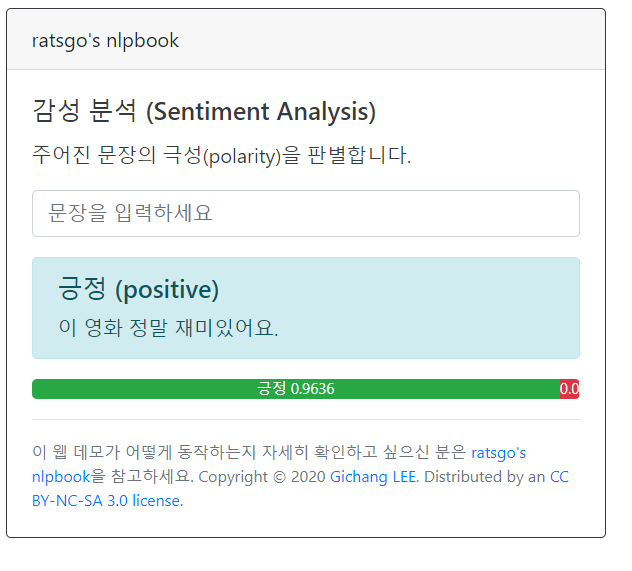

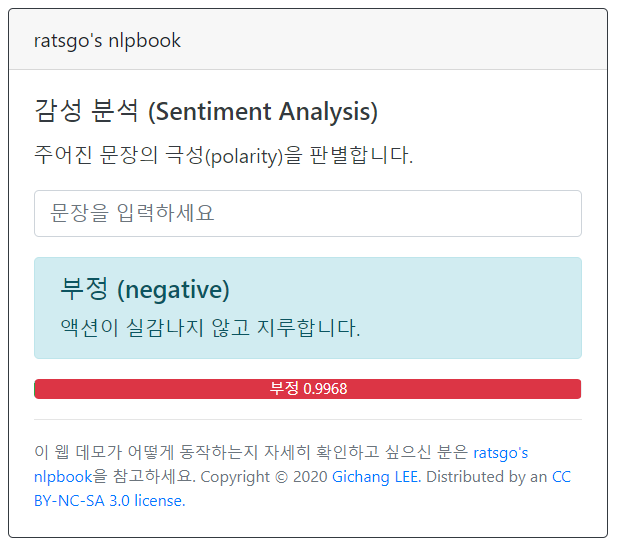